# Figure 2 Analysis: Haar Fluctuation Analysis and Cross-Haar Correlations for the Neutral and Species-level Models

- Figure illustrates community dynamics, the relationship between origination and extinction rate versus species richness, Haar fluctuations, and cross-Haar correlations between a neutral community (exhibiting a stabalzing feedback) and one with continous species generation (random walk). 

- Diversity metrics include a naive metric (not included within the main paper) for origination and extinction rate as well as the use of second-for-third origination, extinction, and range through diversity metric. 

- Scaling exponent estimates are also provided at the end of this notebook for the UNTB and species-level models for the diversity fluctuations.

In [ ]:
# Set User Paths #
src_path = "../Blind_Review_Code_Repository_2025/src/"

In [2]:
# Library Imports
import os
os.chdir(src_path)

# From src
## UNTB Functions
import untbPython
## Diversity Metric Functions
import analysisFunctions 
import divDynFunctions
import samplingFunctions
import diversityMetrics
## Haar Fluctuation Analysis Functions
import haarFluctuationAnalysis
import crossHaarCorrelation

# Other Imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import set_num_threads # Set number of threads for computations
import matplotlib

Below next code blocks are to run the neutral and species-level models. Note that these will save fills to a directory of your choosing for later plotting.

## Simulate and Save UNTB Communities

In [3]:
# UNTB Model Parameters and Save Path
#### Run time about 11 minutes on Mac with 8 threads ####

save_path = "../" # This is the save path for simulation output files
# Please note if paths are not configured properly you could get an error on save in the below code block.

# Simulation Parameters
J = 1000 # Community size
mutation_p = 0.05 # Mutation Rate
death_r = 100 # Deaths per time step
model_n = 13000 # Total number of simulation time steps
cut = 2000 # Number of burn-in time steps
n_repeats = 1 # Number of repeats 

expanded_community = np.repeat(1,J) # Intialize mono-dominate community
time_v = np.arange(cut, model_n) # Create time vector for steps after burn-in
tc = analysisFunctions.firstEigen(death_r, mutation_p, J) # Approximate characteristic timescale for plotting

# Print parameters
print(f"Relaxation Time in log-time: {np.round(np.log10(1/tc),2)}; Death Rate: {death_r}; Speciation Rate: {mutation_p}")


Relaxation Time in log-time: 2.3; Death Rate: 100; Speciation Rate: 0.05


In [ ]:
# Simulate UNTB 
# Note that this code can be easily adapted to do a parameter grid search for neutral model parameter combinations
# This is not included here since the dynamics are consistent across parameter combinations, with community size and variance being the only values that change

for i in range(n_repeats):
    print(f"\nRunning simulation {i+1}/{n_repeats}")

    # --- RESET STORAGE ---
    richness_2f3 = []
    ori_2f3 = []
    exi_2f3 = []
    richness_r = []
    ori_r = []
    exi_r = []
    r_mutations = []

    h_richness = []
    h_ext = []
    h_ori = []
    h_richness_2f3 = []
    h_ext_2f3= []
    h_ori_2f3 = []
    h_time = []
    h_time_2f3 = []

    corr_oe_2f3 = []
    cor_ed_2f3 = []
    corr_od_2f3 = []
    corr_oe = []
    cor_ed = []
    corr_od = []

    untb_results, ancs, desc, n_muts = untbPython.untb_Hankin_Phylo_V2(expanded_community, mutation_probability= mutation_p, death_rate= death_r, generations=model_n, keep=False)

    #########################
    # Calculate naive rates #
    #########################
    # Richness
    unRich = untbPython.return_richness(untb_results)
    unOri, unExt = diversityMetrics.naive_rates(unRich)
    # Truncate by cutoff
    unRich = np.ascontiguousarray(unRich[cut:,:])
    unOri = np.ascontiguousarray(unOri[cut:])
    unExt = np.ascontiguousarray(unExt[cut:])
    n_muts = np.ascontiguousarray(n_muts[cut:])
    # Save these results
    richness_r.append(unRich)
    ori_r.append(unOri)
    exi_r.append(unExt)
    r_mutations.append(n_muts)
    # Haar Calculations
    time_v = np.ascontiguousarray(unRich[:,0], dtype=np.float64)
    haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.asarray(unRich[:,1], dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.asarray(unOri, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.asarray(unExt, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    time_axis = haar_Div[:,0]
    # Save Haar Results
    h_richness.append(haar_Div)
    h_ori.append(haar_oriRT)
    h_ext.append(haar_extRT)   
    h_time.append(time_axis)
    # Cross-Haar Correlations
    corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
    corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
    corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
    corr_oe.append(corr_org_ext)
    cor_ed.append(corr_ext_div)
    corr_od.append(corr_ori_div) 
    #########################

    ##############################
    # Calculate second-for-third #
    ##############################
    # Form species list
    species_list_all = np.arange(1, np.max(untb_results)+1, dtype = np.int64)
    set_num_threads(8) # Set thread number
    spec_dyn = samplingFunctions.retrieve_species_dynamics_numba(untb_results, species_id = species_list_all)
    # Bias the output
    test_spec = np.array(spec_dyn.copy(), dtype=np.int64)
    presence = test_spec[cut:] # Discard burn-in period
    # Get metrics
    # Filter out time steps you will not observe
    occ_list = diversityMetrics.convert_to_dictionary(presence)
    # Diversity Metrics
    # Diversity 
    dynMat = divDynFunctions.binnedToExpandedFad(occ_list)
    # Convert in matrix
    metricMatrix = divDynFunctions.counts(dynMat)
    # Diversity Range Through
    divRT = divDynFunctions.getdivRT(metricMatrix)
    # Diversity Boundary Crossers
    divBC = divDynFunctions.getBCdiversity(metricMatrix)
    # Second for third extinction and origination
    ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
    org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
    # New times are the bin transformed times
    # Drop first and last values so no NAN present
    org2f3 = org2f3[1:-1]
    ext2f3 = ext2f3[1:-1]
    divRT = divRT[1:-1]
    # Save these results
    richness_2f3.append(divRT)
    ori_2f3.append(org2f3)
    exi_2f3.append(ext2f3)
    # Haar Calculations
    time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
    haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    time_axis = haar_Div[:,0]
    # Save Haar Results
    h_richness_2f3.append(haar_Div)
    h_ori_2f3.append(haar_oriRT)
    h_ext_2f3.append(haar_extRT)   
    h_time_2f3.append(time_axis)
    # Cross-Haar Correlations
    corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
    corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
    corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
    corr_oe_2f3.append(corr_org_ext)
    cor_ed_2f3.append(corr_ext_div)
    corr_od_2f3.append(corr_ori_div) 
    ##############################

    # --- SAVE RESULTS FOR THIS RUN ---
    # Need to save this
    data_out = {
        "richness_2f3": richness_2f3,
        "ori_2f3": ori_2f3,
        "exi_2f3": exi_2f3,
        "richness_r": richness_r,
        "ori_r": ori_r,
        "exi_r": exi_r,
        "h_richness": h_richness,
        "h_ext": h_ext,
        "h_ori": h_ori,
        "h_richness_2f3": h_richness_2f3,
        "h_ext_2f3": h_ext_2f3,
        "h_ori_2f3": h_ori_2f3,
        "h_time": h_time,
        "h_time_2f3": h_time_2f3,
        "corr_oe_2f3": corr_oe_2f3,
        "cor_ed_2f3": cor_ed_2f3,
        "corr_od_2f3": corr_od_2f3,
        "corr_oe": corr_oe,
        "cor_ed": cor_ed,
        "corr_od": corr_od,
        "n_muts": n_muts
    }

    filename = f"UNTB_Fig_2_sim_{i}.npz"
    np.savez_compressed(os.path.join(save_path, filename), data_out)

    print(f"Saved run {i+1} results to {filename}")


## Simulate and Save Species-Level Communities

In [4]:
# Species-level Model Parameters and Save Path
#### Run time about 4 minutes on Mac ####

save_path = "../" # This is the save path for simulation output files
# Please note if paths are not configured properly you could get an error on save in the below code block.

# Simulation Parameters
extinction_rate = np.round(0.005,3) # Extinction Rate rounded to the third decimal
speciation_rate = np.round(0.005,3) # Speciation Rate rounded to the third decimal
intial_species_richness = 250 # Initial species richness of community
n_steps = 13000 # Number of model steps
n_repeats = 1 # Number of repeats 

### Note that extinction rate, speciation rate, and neutral process must sum to 1
neutral_rate = 0.99

# Print parameters
print(f"Species-level model speciation rate: {speciation_rate}; extinction rate: {extinction_rate}; starting richness: {intial_species_richness}")

Species-level model speciation rate: 0.005; extinction rate: 0.005; starting richness: 250


In [ ]:
# Simulate species-level model
for i in range(n_repeats):
    print(f"\nRunning simulation {i+1}/{n_repeats}")
    print(f'Speciation Rate: {speciation_rate}; Extinction Rate: {extinction_rate}')

    # --- RESET STORAGE ---
    richness_2f3 = []
    ori_2f3 = []
    exi_2f3 = []
    richness_r = []
    ori_r = []
    exi_r = []
    r_mutations = []

    h_richness = []
    h_ext = []
    h_ori = []
    h_richness_2f3 = []
    h_ext_2f3= []
    h_ori_2f3 = []
    h_time = []
    h_time_2f3 = []

    corr_oe_2f3 = []
    cor_ed_2f3 = []
    corr_od_2f3 = []
    corr_oe = []
    cor_ed = []
    corr_od = []

    # Run random walk model
    RW_Output = untbPython.density_independent_model(intial_species_richness, n_steps, speciation_rate, neutral_rate, extinction_rate)
    richness = [len(i) for i in RW_Output]

    #########################
    # Calculate naive rates #
    #########################
    # Richness
    time_v = np.arange(1, len(richness)+1)
    richAr = np.array([time_v, richness]).T
    unOri, unExt = diversityMetrics.naive_rates(richAr)
    # Truncate by cutoff
    unRich = np.ascontiguousarray(richness)
    unOri = np.ascontiguousarray(unOri)
    unExt = np.ascontiguousarray(unExt)
    # Save these results
    richness_r.append(unRich)
    ori_r.append(unOri)
    exi_r.append(unExt)
    r_mutations.append([])
    # Haar Calculations
    haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.asarray(richness), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.asarray(unOri, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.asarray(unExt, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    time_axis = haar_Div[:,0]
    # Save Haar Results
    h_richness.append(haar_Div)
    h_ori.append(haar_oriRT)
    h_ext.append(haar_extRT)   
    h_time.append(time_axis)
    # Cross-Haar Correlations
    corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
    corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
    corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
    corr_oe.append(corr_org_ext)
    cor_ed.append(corr_ext_div)
    corr_od.append(corr_ori_div) 
    #########################

    ##############################
    # Calculate second-for-third #
    ##############################
    # Ideal Haar fluctuations for the community 
    comm_true = RW_Output.copy()
    # Diversity 
    dynMat = divDynFunctions.binnedToExpandedFad(comm_true)
    # Convert in matrix
    metricMatrix = divDynFunctions.counts(dynMat)
    # Diversity Range Through Metric
    divRT = divDynFunctions.getdivRT(metricMatrix)
    # Second for third extinction and origination
    ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
    org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
    # Replace non-integer values with zero
    ext2f3[np.isnan(ext2f3) | np.isinf(ext2f3)] = 0
    org2f3[np.isnan(org2f3) | np.isinf(org2f3)] = 0
    # New times are the bin transformed times
    # Drop first and last values so no NAN present
    org2f3 = org2f3[1:-1]
    ext2f3 = ext2f3[1:-1]
    divRT = divRT[1:-1]
    # Save these results
    richness_2f3.append(divRT)
    ori_2f3.append(org2f3)
    exi_2f3.append(ext2f3)
    # Haar Calculations
    time_v = np.arange(1, len(divRT) + 1, dtype=np.float64)
    haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
    time_axis = haar_Div[:,0]
    # Save Haar Results
    h_richness_2f3.append(haar_Div)
    h_ori_2f3.append(haar_oriRT)
    h_ext_2f3.append(haar_extRT)   
    h_time_2f3.append(time_axis)
    # Cross-Haar Correlations
    corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
    corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
    corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
    corr_oe_2f3.append(corr_org_ext)
    cor_ed_2f3.append(corr_ext_div)
    corr_od_2f3.append(corr_ori_div) 
    ##############################

    # --- SAVE RESULTS FOR THIS RUN ---
    # Need to save this
    data_out = {
        "richness_2f3": richness_2f3,
        "ori_2f3": ori_2f3,
        "exi_2f3": exi_2f3,
        "richness_r": richness_r,
        "ori_r": ori_r,
        "exi_r": exi_r,
        "h_richness": h_richness,
        "h_ext": h_ext,
        "h_ori": h_ori,
        "h_richness_2f3": h_richness_2f3,
        "h_ext_2f3": h_ext_2f3,
        "h_ori_2f3": h_ori_2f3,
        "h_time": h_time,
        "h_time_2f3": h_time_2f3,
        "corr_oe_2f3": corr_oe_2f3,
        "cor_ed_2f3": cor_ed_2f3,
        "corr_od_2f3": corr_od_2f3,
        "corr_oe": corr_oe,
        "cor_ed": cor_ed,
        "corr_od": corr_od,
        "n_muts": n_muts
    }

    filename = f"RW_Fig_1_sim_{i}.npz"
    np.savez_compressed(os.path.join(save_path, filename), data_out)

## Plot Results

The below code blocks reproduce the manuscript figures along with providing some additional figures illustrating the simulations dynamics. Although range-through-diversity and second-for-third rate are presented in the main text, naive rate metrics are also provided in the below analysis.

In [ ]:
# Load in simulation results for UNTB

# Path where files are saved
untb_save_path = "../UNTB"

# Get all .npz files
all_files = [f for f in os.listdir(untb_save_path) if f.endswith(".npz")]

# Expected keys
keys = [
    "richness_2f3", "ori_2f3", "exi_2f3",
    "richness_r", "ori_r", "exi_r",
    "h_richness", "h_ext", "h_ori",
    "h_richness_2f3", "h_ext_2f3", "h_ori_2f3",
    "h_time", "h_time_2f3",
    "corr_oe_2f3", "cor_ed_2f3", "corr_od_2f3",
    "corr_oe", "cor_ed", "corr_od",
    "n_muts"
]

# Initialize data_out as a dict of empty lists for each key
data_out_untb = {key: [] for key in keys}

# Load and append data from each simulation
for filename in all_files:
    file_path = os.path.join(untb_save_path, filename)
    try:
        npz_file = np.load(file_path, allow_pickle=True)
        ds = npz_file["arr_0"].item()
        
        for key in keys:
            if key in ds:
                data_out_untb[key].append(ds[key])
            else:
                print(f"Warning: Key '{key}' not found in file '{filename}'")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

Text(0.5, 0.96, 'UNTB Results for Naive Richness v. Range-Through Diversity')

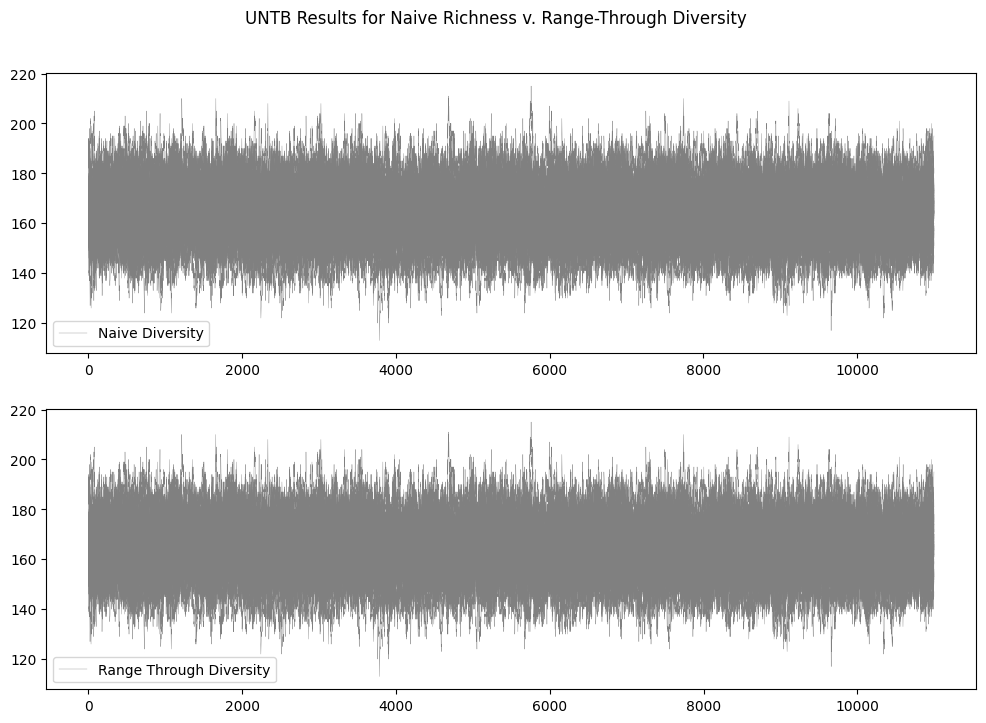

In [5]:
# UNTB: Simple plot showing naive richness versus range-through-diversity
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
num_simulations = len(data_out_untb["h_time"])  # number of simulations loaded

for k in range(num_simulations):
    axs[0].plot(range(len(data_out_untb["richness_r"][k][0][:,1])), data_out_untb["richness_r"][k][0][:,1], color="grey", linestyle = "solid", alpha=1, linewidth = 0.25, label="Naive Diversity" if k==0 else None)
    axs[1].plot(range(len(data_out_untb["richness_2f3"][k][0])), data_out_untb["richness_2f3"][k][0], color="grey", linestyle = "solid", alpha=1, linewidth = 0.25, label="Range Through Diversity" if k==0 else None)

axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
fig.suptitle("UNTB Results for Naive Richness v. Range-Through Diversity", fontsize=12, y=0.96)

In [ ]:
# Load in simulation results for Species-level model

# Path where files are saved
rw_save_path = "../RW"
# Get all .npz files
all_files = [f for f in os.listdir(rw_save_path) if f.endswith(".npz")]

# Expected keys
keys = [
    "richness_2f3", "ori_2f3", "exi_2f3",
    "richness_r", "ori_r", "exi_r",
    "h_richness", "h_ext", "h_ori",
    "h_richness_2f3", "h_ext_2f3", "h_ori_2f3",
    "h_time", "h_time_2f3",
    "corr_oe_2f3", "cor_ed_2f3", "corr_od_2f3",
    "corr_oe", "cor_ed", "corr_od",
    "n_muts"
]

# Initialize data_out as a dict of empty lists for each key
data_out_RW = {key: [] for key in keys}

# Load and append data from each simulation
for filename in all_files:
    file_path = os.path.join(rw_save_path, filename)
    try:
        npz_file = np.load(file_path, allow_pickle=True)
        ds = npz_file["arr_0"].item()
        
        for key in keys:
            if key in ds:
                data_out_RW[key].append(ds[key])
            else:
                print(f"Warning: Key '{key}' not found in file '{filename}'")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

Text(0.5, 0.96, 'Species-level Results for Naive Richness v. Range-Through Diversity')

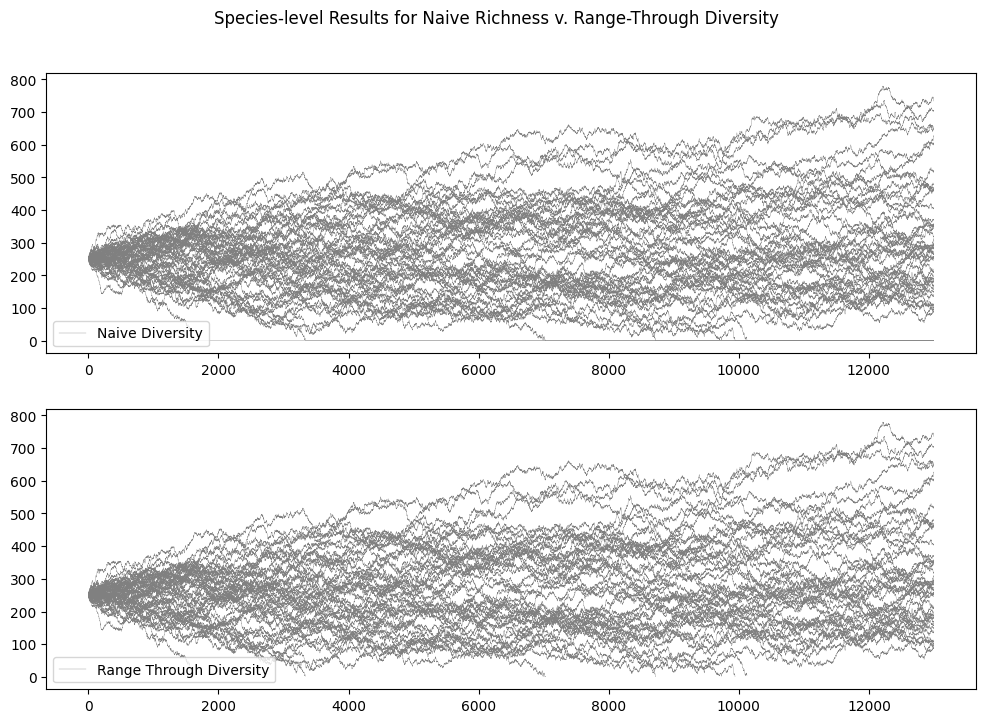

In [7]:
# Species-level: Simple plot showing naive richness versus range-through-diversity
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
num_simulations = len(data_out_RW["h_time"])  # number of simulations loaded

for k in range(num_simulations):
    axs[0].plot(range(len(data_out_RW["richness_r"][k][0])), data_out_RW["richness_r"][k][0], color="grey", linestyle = "solid", alpha=1, linewidth = 0.25, label="Naive Diversity" if k==0 else None)
    axs[1].plot(range(len(data_out_RW["richness_2f3"][k][0])), data_out_RW["richness_2f3"][k][0], color="grey", linestyle = "solid", alpha=1, linewidth = 0.25, label="Range Through Diversity" if k==0 else None)

axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
fig.suptitle("Species-level Results for Naive Richness v. Range-Through Diversity", fontsize=12, y=0.96)

In [8]:
# Plotting helper function for legend
def fix_legend(ax, loc="best", fontsize=8):
    handles, labels = ax.get_legend_handles_labels()

    # Create copies of the handles for legend only
    new_handles = []
    for h in handles:
        if isinstance(h, mlines.Line2D):
            new_h = mlines.Line2D([], [],
                                  color=h.get_color(),
                                  linestyle=h.get_linestyle(),
                                  linewidth=h.get_linewidth(),
                                  marker=h.get_marker(),
                                  label=h.get_label(),
                                  alpha=1.0)  # force alpha=1 for legend only
            new_handles.append(new_h)
        else:
            # fallback for other types (like Patch, etc.)
            new_handles.append(h)

    ax.legend(handles=new_handles, labels=labels, loc=loc, fontsize=fontsize)

### Main Figure 2 Plot for Range-Through Diversity and Second-for-Third Metrics

Important Note: If you have not run enough species-level models whereby richness goes to zero you may not have the negative exponential relationship expected for the origination and extinction rates versus species richness. You can either run more simulations or start the species richness very low.

In [ ]:
# Set file save path 
tiff_save_path = "../Fig2_2f3.tiff"
# Note that tc must be defined from the above code blocks (where UNTB parameters were set)

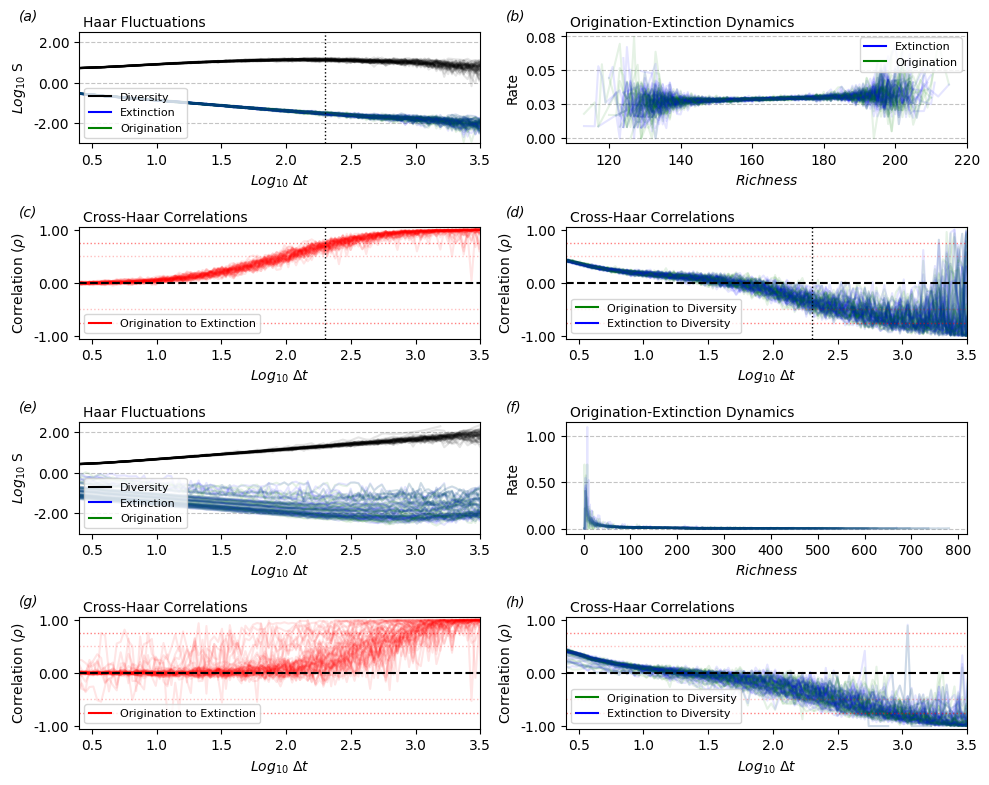

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))

# Smoothing isn't acutally used but if you want to...
kernel = np.ones(4) /4 # Convolution smoothing kernel width; i.e., rolling mean with window of 4

# Stochastic Model
num_simulations = len(data_out_RW["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    # Panal A
    # Haar fluctuations
    # Optionally smooth log values for nicer curves
    axs[2,0].plot(np.log10(data_out_RW["h_richness_2f3"][k][0][:,0]), np.log10(data_out_RW["h_richness_2f3"][k][0][:,1]), color="black", linestyle = "solid", alpha=0.1, label="Diversity" if k==0 else None)
    axs[2,0].plot(np.log10(data_out_RW["h_ext_2f3"][k][0][:,0]), np.log10(data_out_RW["h_ext_2f3"][k][0][:,1]), color="blue",  linestyle = "solid",alpha=0.1, label="Extinction" if k==0 else None)
    axs[2,0].plot(np.log10(data_out_RW["h_ori_2f3"][k][0][:,0]), np.log10(data_out_RW["h_ori_2f3"][k][0][:,1]), color="green",  linestyle = "solid",alpha=0.1, label="Origination" if k==0 else None)
    # Panal B
    # Extinction/Orgination Rates
    common_values = np.unique(data_out_RW["richness_2f3"][k][0])
    v2 = np.array([data_out_RW["richness_2f3"][k][0], data_out_RW["ori_2f3"][k][0], data_out_RW["exi_2f3"][k][0]])
    ori_mean_at_richness = []
    ext_mean_at_richness = []
    for i in range(len(common_values)):
        rv = common_values[i]
        ori_mean_at_richness.append(np.mean(v2[1, v2[0,:] == rv]))
        ext_mean_at_richness.append(np.mean(v2[2, v2[0,:] == rv]))
    oriM2 = [i for i in ori_mean_at_richness]
    extM2 = [i for i in ext_mean_at_richness]
    # Plot
    axs[2,1].plot(common_values, extM2, color="blue", alpha = 0.1,label="Extinction" if k==0 else None)
    axs[2,1].plot(common_values, oriM2, color="green", alpha = 0.1,label="Origination" if k==0 else None)
    # Panal C
    # Cross-Haar Correlations
    axs[3,0].plot(np.log10(data_out_RW["h_richness_2f3"][k][0][:,0]), data_out_RW["corr_oe_2f3"][k][0], c = "red", alpha = 0.1,label="Origination to Extinction" if k==0 else None)
    # Panal D
    # Cross-Haar Correlations Ori/Ext to Diversity
    axs[3,1].plot(np.log10(data_out_RW["h_richness_2f3"][k][0][:,0]), data_out_RW["corr_od_2f3"][k][0], c = "green", alpha = 0.1, label="Origination to Diversity" if k==0 else None)
    axs[3,1].plot(np.log10(data_out_RW["h_richness_2f3"][k][0][:,0]), data_out_RW["cor_ed_2f3"][k][0],  c = "blue", alpha = 0.1, label="Extinction to Diversity" if k==0 else None)


# Neutral Model
num_simulations = len(data_out_untb["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    # Panal A
    # Haar fluctuations
    # Optionally smooth log values for nicer curves
    axs[0,0].plot(np.log10(data_out_untb["h_richness_2f3"][k][0][:,0]),np.log10(data_out_untb["h_richness_2f3"][k][0][:,1]), color="black", linestyle = "solid", alpha=0.1, label="Diversity" if k==0 else None)
    axs[0,0].plot(np.log10(data_out_untb["h_ext_2f3"][k][0][:,0]), np.log10(data_out_untb["h_ext_2f3"][k][0][:,1]), color="blue",  linestyle = "solid",alpha=0.1, label="Extinction" if k==0 else None)
    axs[0,0].plot(np.log10(data_out_untb["h_ori_2f3"][k][0][:,0]), np.log10(data_out_untb["h_ori_2f3"][k][0][:,1]), color="green",  linestyle = "solid",alpha=0.1, label="Origination" if k==0 else None)
    # Panal B
    # Extinction/Orgination Rates
    common_values = np.unique(data_out_untb["richness_2f3"][k][0])
    v2_2f3 = np.array([data_out_untb["richness_2f3"][k][0], data_out_untb["ori_2f3"][k][0], data_out_untb["exi_2f3"][k][0]])
    ori_mean_at_richness = []
    ext_mean_at_richness = []
    for i in range(len(common_values)):
        rv = common_values[i]
        ori_mean_at_richness.append(np.mean(v2_2f3[1, v2_2f3[0,:] == rv]))
        ext_mean_at_richness.append(np.mean(v2_2f3[2, v2_2f3[0,:] == rv]))
    oriM2 = [i for i in ori_mean_at_richness]
    extM2 = [i for i in ext_mean_at_richness]
    # Plot
    axs[0,1].plot(common_values, extM2, color="blue", alpha = 0.1,label="Extinction" if k==0 else None)
    axs[0,1].plot(common_values, oriM2, color="green", alpha = 0.1,label="Origination" if k==0 else None)
    # Panal C
    # Cross-Haar Correlations
    axs[1,0].plot(np.log10(data_out_untb["h_richness_2f3"][k][0][:,0]), data_out_untb["corr_oe_2f3"][k][0], c = "red", alpha = 0.1,label="Origination to Extinction" if k==0 else None)
    # Panal D
    # Cross-Haar Correlations Ori/Ext to Diversity
    axs[1,1].plot(np.log10(data_out_untb["h_richness_2f3"][k][0][:,0]), data_out_untb["corr_od_2f3"][k][0], c = "green", alpha = 0.1, label="Origination to Diversity" if k==0 else None)
    axs[1,1].plot(np.log10(data_out_untb["h_richness_2f3"][k][0][:,0]), data_out_untb["cor_ed_2f3"][k][0],  c = "blue", alpha = 0.1, label="Extinction to Diversity" if k==0 else None)

# Axes labels and limits
axs[2,0].set_xlim(0.4, 3.5)
axs[2,0].set_ylim(-3, 2.5)
axs[3,0].set_xlim(0.4, 3.5)
axs[3,1].set_xlim(0.4, 3.5)

axs[2,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[2,0].set_ylabel(r'$Log_{10}$ S')
axs[2,0].grid(axis='y', linestyle='--', alpha=0.75) 

axs[2,1].set_xlabel(r'$Richness$')
axs[2,1].set_ylabel(r'Rate')
axs[2,1].grid(axis='y', linestyle='--', alpha=0.75) 

axs[3,0].set_ylim(-1.05,1.05)
axs[3,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[3,0].set_ylabel(r'Correlation $(\rho)$')
axs[3,0].axhline(0, c = "black", linestyle = "dashed")
axs[3,0].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,0].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,0].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[3,0].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

axs[3,1].set_ylim(-1.05,1.05)
axs[3,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[3,1].set_ylabel(r'Correlation $(\rho)$')
axs[3,1].axhline(0, c = "black", linestyle = "dashed")
axs[3,1].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,1].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,1].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[3,1].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

# Axes labels and limits
axs[0,0].set_xlim(0.4, 3.5)
axs[0,0].set_ylim(-3, 2.5)
axs[1,0].set_xlim(0.4, 3.5)
axs[1,1].set_xlim(0.4, 3.5)

axs[0,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[0,0].set_ylabel(r'$Log_{10}$ S')
axs[0,0].grid(axis='y', linestyle='--', alpha=0.75) 

axs[0,1].set_xlabel(r'$Richness$')
axs[0,1].set_ylabel(r'Rate')
axs[0,1].grid(axis='y', linestyle='--', alpha=0.75) 

axs[1,0].set_ylim(-1.05,1.05)
axs[1,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,0].set_ylabel(r'Correlation $(\rho)$')
axs[1,0].axhline(0, c = "black", linestyle = "dashed")
axs[1,0].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,0].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,0].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[1,0].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

axs[1,1].set_ylim(-1.05,1.05)
axs[1,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,1].set_ylabel(r'Correlation $(\rho)$')
axs[1,1].axhline(0, c = "black", linestyle = "dashed")
axs[1,1].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,1].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,1].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[1,1].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

# Label Tc
axs[0,0].axvline(np.log10(1/tc), color="black", linestyle=':', linewidth=1)
axs[1,0].axvline(np.log10(1/tc), color="black", linestyle=':', linewidth=1)
axs[1,1].axvline(np.log10(1/tc), color="black", linestyle=':', linewidth=1)

# Legends
fix_legend(axs[2,0], loc="lower left")
fix_legend(axs[3,1], loc="upper right")
fix_legend(axs[3,0], loc="lower left")
fix_legend(axs[3,1], loc="lower left")
fix_legend(axs[0,0], loc="lower left")
fix_legend(axs[0,1], loc="upper right")
fix_legend(axs[1,0], loc="lower left")
fix_legend(axs[1,1], loc="lower left")

subplot_titles = [
    "Haar Fluctuations", 
    "Origination-Extinction Dynamics",
    "Cross-Haar Correlations", 
    "Cross-Haar Correlations",
    "Haar Fluctuations", 
    "Origination-Extinction Dynamics",
    "Cross-Haar Correlations", 
    "Cross-Haar Correlations",
]
subplot_letters = [
    "(a)", 
    "(b)",
    "(c)", 
    "(d)",
    "(e)", 
    "(f)",
    "(g)", 
    "(h)",
]

# Plot Labels
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(0.01, 1.15, subplot_titles[idx], transform=ax.transAxes,
                fontsize=10, fontweight='normal', va='top', ha='left')

# Plot Letters
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(-0.15, 1.2, subplot_letters[idx], transform=ax.transAxes,
                fontsize=10, fontstyle='italic', va='top', ha='left')


# Round all axis to 2 digits
formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.2f}')

for ax_row in axs:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(formatter)
#fig.suptitle("Second-for-Third Metrics for Neutral and Stochastic Speciation Model", fontsize=14, y=1.0)
plt.tight_layout(h_pad=0.75, w_pad=0.4)
plt.savefig(tiff_save_path, format='tiff', dpi=300, bbox_inches='tight',transparent=True)

### Supplemental Plot for Naive Species Richness and Raw Extinction and Origination Rates

In [ ]:
# Set file save path 
tiff_save_path = "../Fig2_naive.tiff"
# Note that tc must be defined from the above code blocks (where UNTB parameters were set)

/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71830/3952674672.py:14: RuntimeWarning: divide by zero encountered in log10
  axs[2,0].plot(np.log10(data_out_RW["h_ori"][k][0][:,0]), np.log10(data_out_RW["h_ori"][k][0][:,1]), color="green", alpha=0.1, label="Origination" if k==0 else None)
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71830/3952674672.py:47: RuntimeWarning: divide by zero encountered in log10
  axs[0,0].plot(np.log10(data_out_untb["h_ori"][k][0][:,0]), np.log10(data_out_untb["h_ori"][k][0][:,1]), color="green", alpha=0.1, label="Origination" if k==0 else None)
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_71830/3952674672.py:46: RuntimeWarning: divide by zero encountered in log10
  axs[0,0].plot(np.log10(data_out_untb["h_ext"][k][0][:,0]), np.log10(data_out_untb["h_ext"][k][0][:,1]), color="blue", alpha=0.1, label="Extinction" if k==0 else None)


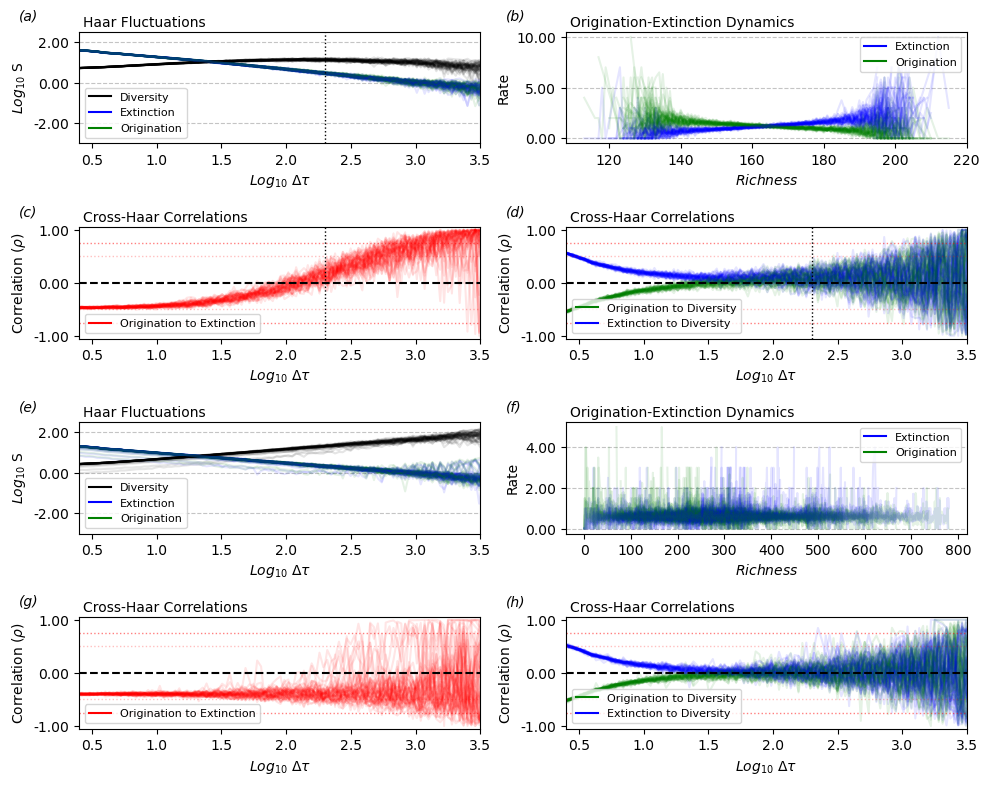

In [ ]:
# Plot of naive metrics

fig, axs = plt.subplots(4, 2, figsize=(10, 8))
kernel = np.ones(4) /4

# Stochastic Model
num_simulations = len(data_out_RW["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    # Panal A
    # Haar fluctuations
    # Optionally smooth log values for nicer curves
    axs[2,0].plot(np.log10(data_out_RW["h_richness"][k][0][:,0]), np.log10(data_out_RW["h_richness"][k][0][:,1]), color="black", alpha=0.1, label="Diversity" if k==0 else None)
    axs[2,0].plot(np.log10(data_out_RW["h_ext"][k][0][:,0]), np.log10(data_out_RW["h_ext"][k][0][:,1]), color="blue", alpha=0.1, label="Extinction" if k==0 else None)
    axs[2,0].plot(np.log10(data_out_RW["h_ori"][k][0][:,0]), np.log10(data_out_RW["h_ori"][k][0][:,1]), color="green", alpha=0.1, label="Origination" if k==0 else None)
    # Panal B
    # Extinction/Orgination Rates
    common_values = np.unique(data_out_RW["richness_r"][k][0])
    v2 = np.array([data_out_RW["richness_r"][k][0], data_out_RW["ori_r"][k][0], data_out_RW["exi_r"][k][0]])
    ori_mean_at_richness = []
    ext_mean_at_richness = []
    for i in range(len(common_values)):
        rv = common_values[i]
        ori_mean_at_richness.append(np.mean(v2[1, v2[0,:] == rv]))
        ext_mean_at_richness.append(np.mean(v2[2, v2[0,:] == rv]))
    oriM2 = [i for i in ori_mean_at_richness]
    extM2 = [i for i in ext_mean_at_richness]
    # Plot
    axs[2,1].plot(common_values, extM2, color="blue", alpha = 0.1,label="Extinction" if k==0 else None)
    axs[2,1].plot(common_values, oriM2, color="green", alpha = 0.1,label="Origination" if k==0 else None)
    # Panal C
    # Cross-Haar Correlations
    axs[3,0].plot(np.log10(data_out_RW["h_richness"][k][0][:,0]), data_out_RW["corr_oe"][k][0], c = "red", alpha = 0.1,label="Origination to Extinction" if k==0 else None)
    # Panal D
    # Cross-Haar Correlations Ori/Ext to Diversity
    axs[3,1].plot(np.log10(data_out_RW["h_richness"][k][0][:,0]),data_out_RW["corr_od"][k][0], c = "green", alpha = 0.1, label="Origination to Diversity" if k==0 else None)
    axs[3,1].plot(np.log10(data_out_RW["h_richness"][k][0][:,0]),data_out_RW["cor_ed"][k][0],  c = "blue", alpha = 0.1, label="Extinction to Diversity" if k==0 else None)


# Neutral Model
num_simulations = len(data_out_untb["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    # Panal A
    # Haar fluctuations
    # Optionally smooth log values for nicer curves
    axs[0,0].plot(np.log10(data_out_untb["h_richness"][k][0][:,0]), np.log10(data_out_untb["h_richness"][k][0][:,1]), color="black", alpha=0.1, label="Diversity" if k==0 else None)
    axs[0,0].plot(np.log10(data_out_untb["h_ext"][k][0][:,0]), np.log10(data_out_untb["h_ext"][k][0][:,1]), color="blue", alpha=0.1, label="Extinction" if k==0 else None)
    axs[0,0].plot(np.log10(data_out_untb["h_ori"][k][0][:,0]), np.log10(data_out_untb["h_ori"][k][0][:,1]), color="green", alpha=0.1, label="Origination" if k==0 else None)
    
    # Panal B
    # Extinction/Orgination Rates
    common_values = np.unique(data_out_untb["richness_r"][k][0][:,1])
    v2 = np.array([ data_out_untb["richness_r"][k][0][:,1], data_out_untb["ori_r"][k][0], data_out_untb["exi_r"][k][0]])

    ori_mean_at_richness = []
    ext_mean_at_richness = []

    for i in range(len(common_values)):
        rv = common_values[i]
        ori_mean_at_richness.append(np.mean(v2[1, v2[0,:] == rv]))
        ext_mean_at_richness.append(np.mean(v2[2, v2[0,:] == rv]))

    oriM2 = [i for i in ori_mean_at_richness]
    extM2 = [i for i in ext_mean_at_richness]

    # Plot
    axs[0,1].plot(common_values, extM2, color="blue", alpha = 0.1,label="Extinction" if k==0 else None)
    axs[0,1].plot(common_values, oriM2, color="green", alpha = 0.1,label="Origination" if k==0 else None)

    # Panal C
    # Cross-Haar Correlations
    axs[1,0].plot(np.log10(data_out_untb["h_richness"][k][0][:,0]), data_out_untb["corr_oe"][k][0], c = "red", alpha = 0.1,label="Origination to Extinction" if k==0 else None)

    # Panal D
    # Cross-Haar Correlations Ori/Ext to Diversity
    axs[1,1].plot(np.log10(data_out_untb["h_richness"][k][0][:,0]),data_out_untb["corr_od"][k][0], c = "green", alpha = 0.1, label="Origination to Diversity" if k==0 else None)
    axs[1,1].plot(np.log10(data_out_untb["h_richness"][k][0][:,0]),data_out_untb["cor_ed"][k][0],  c = "blue", alpha = 0.1, label="Extinction to Diversity" if k==0 else None)

# Axes labels and limits
axs[2,0].set_xlim(0.4, 3.5)
axs[2,0].set_ylim(-3, 2.5)
axs[3,0].set_xlim(0.4, 3.5)
axs[3,1].set_xlim(0.4, 3.5)

axs[2,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[2,0].set_ylabel(r'$Log_{10}$ S')
axs[2,0].grid(axis='y', linestyle='--', alpha=0.75) 

axs[2,1].set_xlabel(r'$Richness$')
axs[2,1].set_ylabel(r'Rate')
axs[2,1].grid(axis='y', linestyle='--', alpha=0.75) 

axs[3,0].set_ylim(-1.05,1.05)
axs[3,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[3,0].set_ylabel(r'Correlation $(\rho)$')
axs[3,0].axhline(0, c = "black", linestyle = "dashed")
axs[3,0].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,0].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,0].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[3,0].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

axs[3,1].set_ylim(-1.05,1.05)
axs[3,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[3,1].set_ylabel(r'Correlation $(\rho)$')
axs[3,1].axhline(0, c = "black", linestyle = "dashed")
axs[3,1].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,1].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[3,1].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[3,1].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

# Axes labels and limits
axs[0,0].set_xlim(0.4, 3.5)
axs[0,0].set_ylim(-3, 2.5)
axs[1,0].set_xlim(0.4, 3.5)
axs[1,1].set_xlim(0.4, 3.5)

axs[0,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[0,0].set_ylabel(r'$Log_{10}$ S')
axs[0,0].grid(axis='y', linestyle='--', alpha=0.75) 

axs[0,1].set_xlabel(r'$Richness$')
axs[0,1].set_ylabel(r'Rate')
axs[0,1].grid(axis='y', linestyle='--', alpha=0.75) 

axs[1,0].set_ylim(-1.05,1.05)
axs[1,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,0].set_ylabel(r'Correlation $(\rho)$')
axs[1,0].axhline(0, c = "black", linestyle = "dashed")
axs[1,0].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,0].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,0].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[1,0].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)

axs[1,1].set_ylim(-1.05,1.05)
axs[1,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,1].set_ylabel(r'Correlation $(\rho)$')
axs[1,1].axhline(0, c = "black", linestyle = "dashed")
axs[1,1].axhline(0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,1].axhline(-0.75, color="red", linestyle=':', linewidth=1, alpha = 0.5)
axs[1,1].axhline(0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
axs[1,1].axhline(-0.5, color="red", linestyle=':', linewidth=1, alpha = 0.25)
# Label Tc
axs[0,0].axvline(np.log10(1/tc), color="black", linestyle=':', linewidth=1)
axs[1,0].axvline(np.log10(1/tc), color="black", linestyle=':', linewidth=1)
axs[1,1].axvline(np.log10(1/tc), color="black", linestyle=':', linewidth=1)
# Legends
fix_legend(axs[2,0], loc="lower left")
fix_legend(axs[2,1], loc="upper right")
fix_legend(axs[3,0], loc="lower left")
fix_legend(axs[3,1], loc="lower left")
fix_legend(axs[0,0], loc="lower left")
fix_legend(axs[0,1], loc="upper right")
fix_legend(axs[1,0], loc="lower left")
fix_legend(axs[1,1], loc="lower left")

subplot_titles = [
    "Haar Fluctuations", 
    "Origination-Extinction Dynamics",
    "Cross-Haar Correlations", 
    "Cross-Haar Correlations",
    "Haar Fluctuations", 
    "Origination-Extinction Dynamics",
    "Cross-Haar Correlations", 
    "Cross-Haar Correlations",
]

subplot_letters = [
    "(a)", 
    "(b)",
    "(c)", 
    "(d)",
    "(e)", 
    "(f)",
    "(g)", 
    "(h)",
]


for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(0.01, 1.15, subplot_titles[idx], transform=ax.transAxes,
                fontsize=10, fontweight='normal', va='top', ha='left')

# Plot Letters
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(-0.15, 1.2, subplot_letters[idx], transform=ax.transAxes,
                fontsize=10, fontstyle='italic', va='top', ha='left')



# Round all axis to 2 digits
formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.2f}')

for ax_row in axs:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(formatter)

#fig.suptitle("Second-for-Third Metrics for Neutral and Stochastic Speciation Model", fontsize=14, y=1.0)
plt.tight_layout(h_pad=0.75, w_pad=0.4)

#plt.savefig(tiff_save_path, format='tiff', dpi=300, bbox_inches='tight',transparent=True)

## Scaling Exponents Estimates

#### UNTB Scaling Exponent Estimates for Fluctuations

In [29]:
# Store results for scaling estimates
slope_data = {
    "sim_id": [],
    "slope_front_diversity": [],
    "slope_back_diversity": [],
    "intercept_front_diversity": [],
    "intercept_back_diversity": [],
    "slope_extinction": [],
    "slope_origination": []
}

In [30]:
# Estimate
num_simulations = len(data_out_untb["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    
    # --- Get x and y ---
    x = data_out_untb["h_richness_2f3"][k][0][:, 0]
    y = data_out_untb["h_richness_2f3"][k][0][:, 1]

    ###########
    # Front Half (Diversity)
    ###########
    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 0.5
    mask_h = lx <= 3.5 
    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = min(lx)
    H_c = np.log10(1/tc)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_front = coeffs[0]
    intercept_front = coeffs[1]
    x_bins_front = x_bins

    ###########
    # Back Half (Diversity)
    ###########
    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 0.5
    mask_h = lx <= 3.5

    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = np.log10(1/tc)
    H_c = max(lx)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_back = coeffs[0]
    intercept_back = coeffs[1]
    x_bins_back = x_bins

    ###########
    # Origination
    ###########'
    x = data_out_untb["h_ori_2f3"][k][0][:,0]
    y = data_out_untb["h_ori_2f3"][k][0][:,1]

    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 1.0
    mask_h = lx <= 3.0

    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = min(lx)
    H_c = max(lx)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_ori = coeffs[0]

    ###########
    # Extinction
    ###########
    x = data_out_untb["h_ext_2f3"][k][0][:,0]
    y = data_out_untb["h_ext_2f3"][k][0][:,1]

    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 0.5
    mask_h = lx <= 3.5

    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = min(lx)
    H_c = max(lx)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_ext = coeffs[0]

    ###########
    # Store results
    ###########
    slope_data["sim_id"].append(k)
    slope_data["slope_front_diversity"].append(slope_front)
    slope_data["slope_back_diversity"].append(slope_back)
    slope_data["intercept_front_diversity"].append(intercept_front)
    slope_data["intercept_back_diversity"].append(intercept_back)
    slope_data["slope_origination"].append(slope_ori)
    slope_data["slope_extinction"].append(slope_ext)

In [31]:
# Output scaling exponent estimates

slope_df = pd.DataFrame(slope_data)

# Show table (optional)
#print(slope_df)

# Compute summary stats
summary_nt = slope_df.describe().loc[["mean", "std"]]
print("\nSummary of slope estimates:")
print(summary_nt)


Summary of slope estimates:
      sim_id  slope_front_diversity  slope_back_diversity  \
mean     0.0                0.23035             -0.392341   
std      NaN                    NaN                   NaN   

      intercept_front_diversity  intercept_back_diversity  slope_extinction  \
mean                   0.147025                  1.541575         -0.517902   
std                         NaN                       NaN               NaN   

      slope_origination  
mean          -0.507533  
std                 NaN  


In [ ]:
## Illustrate plot of estimated slopes on UNTB Haar fluctuations

fig, axs = plt.subplots(1,1)
# Neutral Model
num_simulations = len(data_out_untb["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    # Panal A
    # Haar fluctuations
    # Optionally smooth log values for nicer curves
    axs.plot(np.log10(data_out_untb["h_richness_2f3"][k][0][:,0]),np.log10(data_out_untb["h_richness_2f3"][k][0][:,1]), color="black", linestyle = "solid", alpha=0.1, label="Diversity" if k==0 else None)
    axs.plot(np.log10(data_out_untb["h_ext_2f3"][k][0][:,0]), np.log10(data_out_untb["h_ext_2f3"][k][0][:,1]), color="blue",  linestyle = "solid",alpha=0.1, label="Extinction" if k==0 else None)
    axs.plot(np.log10(data_out_untb["h_ori_2f3"][k][0][:,0]), np.log10(data_out_untb["h_ori_2f3"][k][0][:,1]), color="green",  linestyle = "solid",alpha=0.1, label="Origination" if k==0 else None)

mean_line_f = np.mean(slope_df.loc[:,"slope_front_diversity"]) * x_bins_front + np.mean(slope_df.loc[:,"intercept_front_diversity"])
mean_line_b = np.mean(slope_df.loc[:,"slope_back_diversity"]) * x_bins_back + np.mean(slope_df.loc[:,"intercept_back_diversity"])
mean_line_b = np.mean(slope_df.loc[:,"slope_back_diversity"]) * x_bins_back + np.mean(slope_df.loc[:,"intercept_back_diversity"])

#print(f'{probs[i]} {bin_size[k]} {coeffs[0]}')
axs.plot(x_bins_front, mean_line_f, c = "red", linewidth = 1)
axs.plot(x_bins_back, mean_line_b, c = "red", linewidth = 1)

#### Species-Level Model Scaling Exponent Estimates for Fluctuations

In [33]:
# Store results for scaling estimates
slope_data_sto = {
    "sim_id": [],
    "slope_diversity": [],
    "slope_extinction": [],
    "slope_origination": []
}

In [34]:
# Estimate
num_simulations = len(data_out_RW["h_time"])  # number of simulations loaded
for k in range(num_simulations):
    
    # --- Get x and y ---
    x = data_out_RW["h_richness_2f3"][k][0][:,0]
    y = data_out_RW["h_richness_2f3"][k][0][:,1]

    ###########
    # Front Half (Diversity)
    ###########
    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 1.0
    mask_h = lx <= 3.0
    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = min(lx)
    H_c = max(lx)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_diversity = coeffs[0]

    ###########
    # Origination
    ###########'
    x = data_out_RW["h_ori_2f3"][k][0][:,0]
    y = data_out_RW["h_ori_2f3"][k][0][:,1]

    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 1.0
    mask_h = lx <= 2.5

    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = min(lx)
    H_c = max(lx)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_ori = coeffs[0]

    ###########
    # Extinction
    ###########
    x = data_out_RW["h_ext_2f3"][k][0][:,0]
    y = data_out_RW["h_ext_2f3"][k][0][:,1]

    lx = np.log10(x)
    yx = np.log10(y)

    mask_l = lx >= 0.5
    mask_h = lx <= 2.5

    lx = lx[mask_l & mask_h]
    yx = yx[mask_l & mask_h]

    L_c = min(lx)
    H_c = max(lx)

    x_bins, bin_avg, o_bin, o_bin_avg = analysisFunctions.bin_data_max_log_bin(np.array([lx, yx]), 5, h_cut = H_c, l_cut = L_c)
    na_mask = ~np.isnan(bin_avg)
    coeffs = analysisFunctions.linregress_wrapper(np.array([x_bins[na_mask], bin_avg[na_mask]]))
    slope_ext = coeffs[0]

    ###########
    # Store results
    ###########
    slope_data_sto["sim_id"].append(k)
    slope_data_sto["slope_diversity"].append(slope_diversity)
    slope_data_sto["slope_origination"].append(slope_ori)
    slope_data_sto["slope_extinction"].append(slope_ext)

In [35]:
# Output scaling exponent estimates
slope_df_sto = pd.DataFrame(slope_data_sto)

# Show table (optional)
#print(slope_df_sto)

# Compute summary stats
summary_sto = slope_df_sto.describe().loc[["mean", "std"]]
print("\nSummary of slope estimates:")
print(summary_sto)


Summary of slope estimates:
      sim_id  slope_diversity  slope_extinction  slope_origination
mean     0.0         0.499334         -0.489084           -0.49769
std      NaN              NaN               NaN                NaN


### Origination and Extinction Rate for Random Walk Model

Under perfect sampling, the second-for-third equation greatly simplifies as we are now observing every species across all time intervals:

$E = \frac{s_{1} - s_{3}}{t_{2} - p}$

For scenarios of perfect sampling $p = 0$ as well as $s_{3} = 0$. We are then left with the actual extinction or speciation rates per interval:

$E = \frac{s_{1}}{t_{2}}$

https://rdrr.io/cran/divDyn/man/divDyn.html?utm_source=chatgpt.com

Additioanlly, second-for-third origination and extinction rates arises from the transformation of the second-for-third origination and extinction proportions with the following function (example only with extinction):

$Rate_{ext2f3} = log_{10}(\frac{1}{1 - E2f3})$

The casue of the negative exponental relationship between extinction / origination rate and species richness is due to small communities creating an upward bias in $E = \frac{s_{1}}{t_{2}}$.

In [50]:
# Extinction/Orgination Rates
common_values = np.unique(data_out_RW["richness_2f3"][k][0])
v2 = np.array([data_out_RW["richness_2f3"][k][0], data_out_RW["ori_2f3"][k][0], data_out_RW["exi_2f3"][k][0]])
ori_mean_at_richness = []
ext_mean_at_richness = []
for i in range(len(common_values)):
    rv = common_values[i]
    ori_mean_at_richness.append(np.mean(v2[1, v2[0,:] == rv]))
    ext_mean_at_richness.append(np.mean(v2[2, v2[0,:] == rv]))
oriM2 = [i for i in ori_mean_at_richness]
extM2 = [i for i in ext_mean_at_richness]

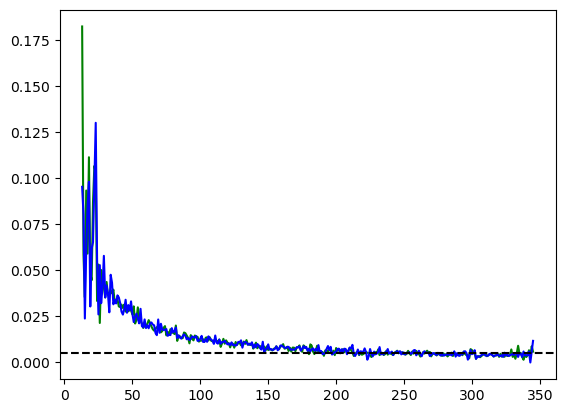

In [51]:
plt.plot(common_values, oriM2, c = "green")
plt.plot(common_values, extM2, c = "blue")
plt.axhline(0.005, c = "black", linestyle = "dashed")